# How much of the heat transport range is explained by the ASC variability?

I want to figure out a visual way to explain a little better the results of our ASC paper, i.e., the dynamics of ASC/CSHT is valied, but doesnt explain the bulk of the CSHT varition. For that, I think it would be interesting to report the range of CSHT variability in TW that is explained by the relationship between the variables. That would show that although there is a valid relationship between them, ithis relationship dont control the CSHT. Let's try to do that plot in this notebook

In [1]:
# Load necessary modules
import intake
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import logging
import matplotlib.cm as cm
from xhistogram.xarray import histogram
import warnings
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
client = Client(threads_per_worker = 1)

In [3]:
catalog = intake.cat.access_nri
ylength=580

In [4]:
#in this definition, no frequency can be used only for static data
def importer(experiment,catalog,variable, frequency = 'fx',start_time=0,end_time=0):
    warnings.filterwarnings('ignore')
    if experiment== "panant-01-zstar-ACCESSyr2":
        var = catalog[experiment].search(variable=variable, frequency = frequency).to_dask(xarray_open_kwargs={'decode_timedelta':True})
    else: 
        #other resolutions have the same variable with z_l and z_l_sub z dim in different times.
        # I will filter to the time I want knowing th their specificities
        #IOW this fix works just for the models and variables used in this notebook
        if variable=='uo' or variable=='vo':
            var = catalog[experiment].search(variable=variable, frequency = frequency)
            keysnames = var.keys() ; search_term = "z_l_sub01"
            matches = [s for s in keysnames if search_term in s]
            var = catalog[experiment].search(variable=variable, frequency = frequency,file_id = matches).to_dask(xarray_open_kwargs={'decode_timedelta':True})
        else:
            var = catalog[experiment].search(variable=variable, frequency = frequency).to_dask(xarray_open_kwargs={'decode_timedelta':True})
    
    if start_time!=0:
        time_slice='slice(start_time,end_time)'
        return eval("var." + variable + ".sel(time=" + time_slice + ")")
    elif start_time ==0:
        return eval("var." + variable)

### Importing heat transport and slope current files

In [5]:
#importing CSHT along for reference
#lighter CSHT matrix to make easier to find TS along isobath
CSHT_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/WMbins_daily_rho/*')
CSHT_along = CSHT_along.isel(time=0).drop('time')
#importing monthly potrho0 along contour
pot_rho0_along_contour = xr.open_dataset('/g/data/x77/wf4500/ASC_project/Post_process/rho0_along_contour.nc')
#importing 3 degrees binned u_along for reference too
#importing the daily ualong in z coords, 3deg binned 
u_along_binned_z = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/ASC_speed/daily_z_3deg/along_slope/*')

In [6]:
#area
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'
area = importer(iaf_cycle3,catalog,'area_t').isel(yt_ocean=slice(0,ylength))
area_transect = area.sel(xt_ocean = CSHT_along.lon_along_contour,yt_ocean=CSHT_along.lat_along_contour,method='nearest')
area_transect.load()
print('Loaded area along the isobath')

Loaded area along the isobath


In [7]:
# #first, creating the Z mask so we make sure we get the right sigmas in the right locations
CSHTZC_z = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/daily_z/*')

In [8]:
#improting masks
# Daily age mask
age_mask_daily = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/age_mask_daily/OM2_01_iaf_cycle3/*.nc')
# monthly water mass mask 
age_mask_monthly = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/**_age_mask.nc')

In [9]:
#importing CSHT in density bins
CSHT_along_10deg = xr.open_mfdataset('/g/data/e14/fbd581/ASC_project/Lon_binning/CSHT_ZC_potrho0_10degBins.nc',\
                               chunks = {'time' : 100,'lon_bins':12})

In [10]:
age_mask = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/**_age_mask.nc')

In [11]:
daily_age_mask = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/age_mask_daily/OM2_01_iaf_cycle3/*.nc')

In [12]:
asc_speed_daily = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/ASC_sigma_daily_10deg/OM2_01_iaf_cycle3/*.nc')

In [13]:
Volume_daily = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/volume_daily_10deg/OM2_01_iaf_cycle3/VOL*.nc')

In [14]:
u_daily_along_CDW = ((asc_speed_daily.U*daily_age_mask.CDW_mask*Volume_daily.Volume).sum('potrho0')/(daily_age_mask.CDW_mask*Volume_daily.Volume).sum('potrho0')).compute()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


In [15]:
#annual mean CSHT from CDW
CSHT_CDW = (CSHT_along_10deg.CSHT_ZC_lon_binned * age_mask_daily.CDW_mask).sum('potrho0').compute()


### Importing pre-calculated slopes and $r^2$

In [16]:
files_path = '/g/data/ik11/users/wf4500/ASC_project_files/' # 10deg
file_extension = 'agemaskCDW_volav'
file_extension_daily_clima = 'agemaskCDW_daily'

ds = xr.open_dataset(files_path + 'r_sq_annual_10degBins_' + file_extension + '_corr.nc')
r_sq_annual_10deg = ds.r_sq_annual
ds.close()
ds = xr.open_dataset(files_path + 'r_sq_all_10degBins_' + file_extension + '_corr.nc')
r_sq_all_10deg = ds.r_sq_all
ds.close()



ds = xr.open_dataset(files_path + 'r_sq_clima_10degBins_' + file_extension_daily_clima + '_APR10.nc')
r_sq_daily_10deg = ds.r_sq_clim
ds.close()
ds = xr.open_dataset(files_path + 'r_sq_clima_10degBins_' + file_extension_daily_clima + '_APR10_noZC.nc')
r_sq_daily_10deg_noZC = ds.r_sq_clim
ds.close()


ds = xr.open_dataset(files_path + 'slope_annual_10degBins_' + file_extension + '_corr.nc')
slope_sq_annual_10deg = ds.slope_annual
ds.close()
ds = xr.open_dataset(files_path + 'slope_all_10degBins_' + file_extension + '_corr.nc')
slope_sq_all_10deg = ds.slope_all
ds.close()



ds = xr.open_dataset(files_path + 'slope_clima_10degBins_' + file_extension_daily_clima + '_APR10.nc')
slope_sq_daily_10deg = ds.slope_clima
ds.close()
ds = xr.open_dataset(files_path + 'slope_clima_10degBins_' + file_extension_daily_clima + '_APR10_noZC.nc')
slope_sq_daily_10deg_noZC = ds.slope_clima
ds.close()

 ### Calculating ranges for each bin

First the plain ranges

In [19]:
#Slope current ranges per bin

ASC_range_10deg = u_daily_along_CDW.max('time') - u_daily_along_CDW.min('time')
#heat transsport ranges per bin
CSHT_CDW_range_10deg = (CSHT_CDW.max('time') - CSHT_CDW.min('time'))*1e-12 #Terrawatts


Second, the interannual ranges

In [106]:
#Slope Current
ASC_CDW_annual =  u_daily_along_CDW.resample(time='1Y').mean()
ASC_CDW_annual_range  =ASC_CDW_annual.max('time') - ASC_CDW_annual.min('time')


#Heat transport
CSHT_CDW_annual =  CSHT_CDW.resample(time='1Y').mean()
CSHT_CDW_annual_range  = (CSHT_CDW_annual.max('time') - CSHT_CDW_annual.min('time'))*1e-12 #Terrawatts

Third, calculating the climatological range

In [107]:
#Slope current
ASC_CDW_clim =  u_daily_along_CDW.groupby('time.dayofyear').mean().isel(dayofyear=slice(0,365))
ASC_CDW_clim_range =ASC_CDW_clim.max('dayofyear') - ASC_CDW_clim.min('dayofyear')

#Heat transport
CSHT_CDW_clim = CSHT_CDW.groupby('time.dayofyear').mean().isel(dayofyear=slice(0,365))
CSHT_CDW_clim_range = (CSHT_CDW_clim.max('dayofyear') - CSHT_CDW_clim.min('dayofyear'))*1e-12 #Terrawatts

 ### Calculating explained range of Heat transport range in each bin

In [113]:
CSHT_CDW_annual_explained =( ((slope_sq_annual_10deg**2)**0.5) *ASC_CDW_annual_range)
CSHT_CDW_clim_explained =( ((slope_sq_daily_10deg**2)**0.5) *ASC_CDW_clim_range)


In [115]:
#cases where we used the total range instad of the interannual or seasonsl ranges
CSHT_CDW_annual_explained2 =( ((slope_sq_annual_10deg**2)**0.5) *ASC_range_10deg)
CSHT_CDW_clim_explained2 =( ((slope_sq_daily_10deg**2)**0.5) *ASC_range_10deg)

In [116]:
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
longitude_inds = np.array([5,36-15, 14, 3,10,17,36-12,36-10, 36-1,1])
regions_abridged = ['Mertz','WAP', 'Getz', 'Totten',\
           'Glomar', 'Amundsen', 'Filchner', \
           'Riiser-Larsen', 'Amery', 'Denman']

 ### Calculating explained standard deviation of Heat transport range in each bin

In [132]:
#annual standard deviations
ASC_CDW_annual_std =ASC_CDW_annual.std('time')
CSHT_CDW_annual_std = CSHT_CDW_annual.std('time')

#cliamtology standard deviations
ASC_CDW_clim_std =ASC_CDW_clim.std('dayofyear')
CSHT_CDW_clim_std =CSHT_CDW_clim.std('dayofyear')

In [134]:
CSHT_CDW_Annual_explained_std =  (r_sq_annual_10deg**0.5) * CSHT_CDW_annual_std
CSHT_CDW_clim_explained_std =  (r_sq_daily_10deg**0.5) * CSHT_CDW_clim_std

 ### Bar charts - explained standard deviation

Text(0.5, 0, 'Longitude')

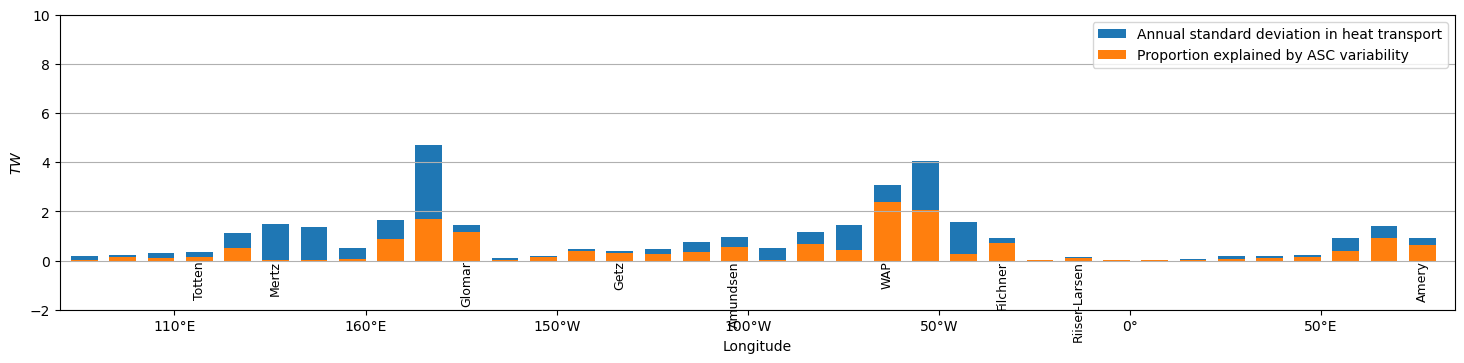

In [143]:
plt.figure(figsize=(18,9))
plt.subplots_adjust( hspace=.35)
#fig,ax_cric = plt.subplots(nrows = 1,ncols = 1,figsize = (10,5))

ax_cric0 = plt.subplot(2,1,1)
plt.bar(CSHT_CDW_annual_std.lon_bins,CSHT_CDW_annual_std*1e-12,width=7,label='Annual standard deviation in heat transport')
plt.bar(CSHT_CDW_Annual_explained_std.lon_bins,CSHT_CDW_Annual_explained_std*1e-12,width=7,label='Proportion explained by ASC variability')

plt.legend()
plt.grid(axis='y')
plt.ylabel('$TW$')
plt.ylim(-2,10)
for i in range(9):
    plt.text(r_sq_annual_10deg.lon_bins[longitude_inds[i]], 0, regions_abridged[i], rotation=90,fontsize=9, va='top', ha='center',color='black')
#plt.title('[a] Zonal convergence effect on $r^2_{interannual}$')
#plt.yticks([0,.2,.4,.6,.8,1])
plt.xlim(-280,85)
ax_cric0.xaxis.set_major_formatter(LongitudeFormatter())
plt.xlabel('Longitude')

 ### Bar charts - explained range

In [154]:
variance_test =1000 #TW**2
r2_test = 0.4 

variance_explained = variance_test*r2_test
variance_explained

400.0

In [159]:
#standard deviation in terrawatts
variance_test**0.5

31.622776601683793

In [160]:
#TWof standar deviation explained
(r2_test **0.5)* (variance_test**0.5)

20.0

Text(0.5, 0, 'Longitude')

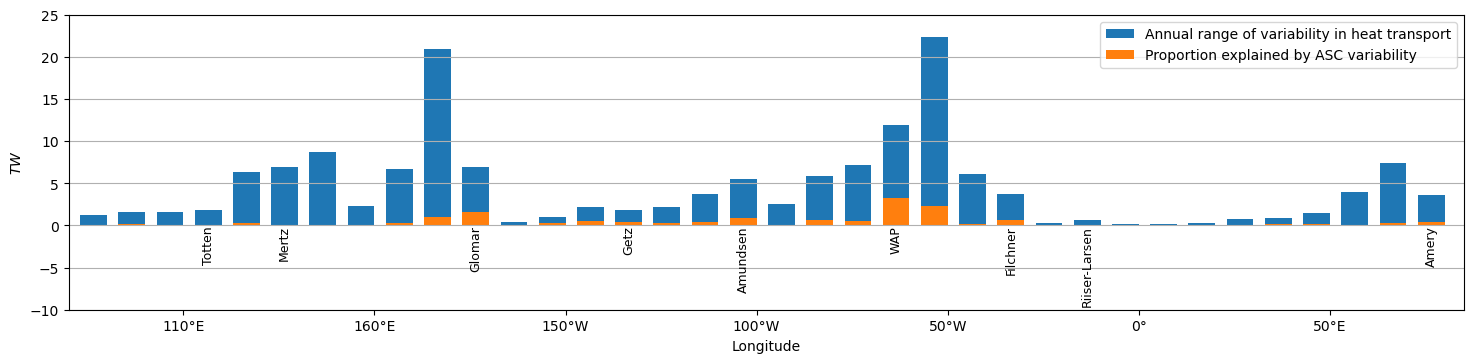

In [144]:
plt.figure(figsize=(18,9))
plt.subplots_adjust( hspace=.35)
#fig,ax_cric = plt.subplots(nrows = 1,ncols = 1,figsize = (10,5))

ax_cric0 = plt.subplot(2,1,1)
plt.bar(CSHT_CDW_annual_range.lon_bins,CSHT_CDW_annual_range,width=7,label='Annual range of variability in heat transport')
plt.bar(CSHT_CDW_annual_explained.lon_bins,CSHT_CDW_annual_explained,width=7,label='Proportion explained by ASC variability')

plt.legend()
plt.grid(axis='y')
plt.ylabel('$TW$')
plt.ylim(-10,25)
for i in range(9):
    plt.text(r_sq_annual_10deg.lon_bins[longitude_inds[i]], 0, regions_abridged[i], rotation=90,fontsize=9, va='top', ha='center',color='black')
#plt.title('[a] Zonal convergence effect on $r^2_{interannual}$')
#plt.yticks([0,.2,.4,.6,.8,1])
plt.xlim(-280,85)
ax_cric0.xaxis.set_major_formatter(LongitudeFormatter())
plt.xlabel('Longitude')

Text(0.5, 0, 'Longitude')

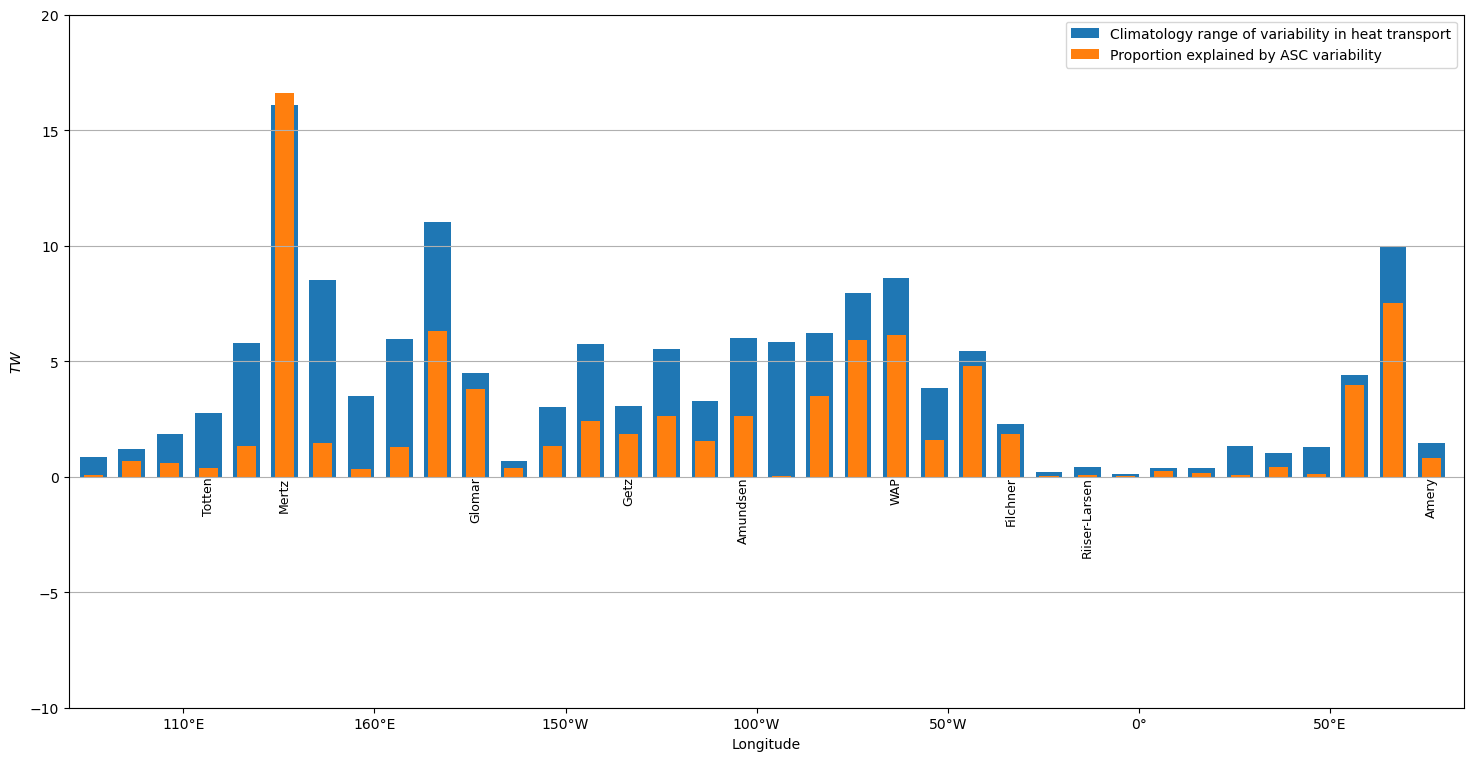

In [152]:
plt.figure(figsize=(18,9))
plt.subplots_adjust( hspace=.35)
#fig,ax_cric = plt.subplots(nrows = 1,ncols = 1,figsize = (10,5))

ax_cric0 = plt.subplot(1,1,1)
plt.bar(CSHT_CDW_clim_range.lon_bins,CSHT_CDW_clim_range,width=7,label='Climatology range of variability in heat transport')
plt.bar(CSHT_CDW_clim_explained.lon_bins,CSHT_CDW_clim_explained,width=5,label='Proportion explained by ASC variability')

plt.legend()
plt.grid(axis='y')
plt.ylabel('$TW$')
plt.ylim(-10,20)
for i in range(9):
    plt.text(r_sq_annual_10deg.lon_bins[longitude_inds[i]], 0, regions_abridged[i], rotation=90,fontsize=9, va='top', ha='center',color='black')
#plt.title('[a] Zonal convergence effect on $r^2_{interannual}$')
#plt.yticks([0,.2,.4,.6,.8,1])
plt.xlim(-280,85)
ax_cric0.xaxis.set_major_formatter(LongitudeFormatter())
plt.xlabel('Longitude')